## Supervised Model
### Approach
To complement the unsupervised approaches, I created a supervised model to predict the GO IDs from the protein embeddings. Similarly to the unsupervised approaches, I first reduce the dimensionality of the protein embeddings with a TruncatedSVD models and use these embeddings for model training.

I chose to implement an XGBoost model since it is able to handle high dimensional data and it can train reasonably quick. To optimize the model, I trained a number of models across a range of values for the n_estimator parameter. The n_estimator parameter represents the number of round of boosting that the model will perform. This parameter can improve the quality of the model but it may also cause the model to overfit. By measuring the train and test accuracies at every value for n_estimators, I prevent overfitting.

### Results
The parameter optimization step showed that 200 rounds of boosting was the ideal number. This is evidenced by a high accuraccy on both the training and test datasets. However the rate at which the accuraccy improves shows that any subsequent boosting rounds after 200 may lead to overfitting.

As for the accuraccy, the model gave an accuraccy of 0.97 on the training dataset and 0.78 on the test dataset. This is an good result and may be further improved by optimizing the other model hyperparameters.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio import SeqIO

dataset = pd.read_csv("dataset_clean.tsv", sep="\t", dtype=str)
dataset["Gene Ontology IDs"] = dataset["Gene Ontology IDs"].str.split("; ")
dataset["Pfam"] = dataset["Pfam"].str.rstrip(";").str.split(";")
ids = dataset["Entry Name"].values
go_ids = dataset["Gene Ontology IDs"].values
pfam_ids = dataset["Pfam"].values
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572970 entries, 0 to 572969
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Entry Name         572970 non-null  object
 1   Sequence           572970 non-null  object
 2   Gene Ontology IDs  552114 non-null  object
 3   Pfam               543927 non-null  object
dtypes: object(4)
memory usage: 17.5+ MB
None


In [2]:
# Create a dictionary to map each sequence to its corresponding GO and Pfam IDs
mapping = {}
go_slim_mapping_file = pd.read_csv("go_mapping.tsv", dtype=str)
go_slim_mapping = go_slim_mapping_file.set_index("original_term")["go_slim_term"].to_dict()
#Replace GO IDs with their corresponding GO Slim IDs
for index, item in enumerate(go_ids):
    tmp = []
    if type(item) == float and pd.isna(item):
        go_ids[index] = np.nan
        continue
    for go_id in item:
        if go_id in go_slim_mapping and go_slim_mapping[go_id] and not pd.isna(go_slim_mapping[go_id]):
            all_terms = go_slim_mapping[go_id].split(";")
            for term in all_terms:
                tmp.append(term)
    if tmp:
        # Set the overall term to the most frequent term
        overall_terms = max(set(tmp), key=tmp.count)
        go_ids[index] = overall_terms
    else:
        go_ids[index] = np.nan
dataset["Gene Ontology IDs"] = go_ids

In [3]:
# Count how many unique GO IDs are in the dataset
import itertools
unique_go_ids = set(go_ids)
print(f"Number of unique GO IDs: {len(unique_go_ids)}")
# Print number of nas in the dataset
print(f"Number of proteins with no GO IDs: {sum(pd.isna(go_ids))}")
print(len(go_ids))
# filter out the pfam ids that are null
all_pfam_ids = [x for x in pfam_ids if type(x) == list and len(x) > 0]
unique_pfam_ids = set(itertools.chain.from_iterable(all_pfam_ids))
print(f"Number of unique Pfam IDs: {len(unique_pfam_ids)}")
# Print number of nas in the dataset
print(f"Number of proteins with no Pfam IDs: {sum(pd.isna(pfam_ids))}")

Number of unique GO IDs: 139
Number of proteins with no GO IDs: 45319
572970
Number of unique Pfam IDs: 16584
Number of proteins with no Pfam IDs: 29043


In [4]:
# Load the embeddings
for i in range(1,12):
    res = np.load(f"embeddings_{i}.npy")
    if i == 1:
        protein_embeddings = res
    else:
        protein_embeddings = np.concatenate((protein_embeddings, res), axis=0)
    # Print how many zero vectors are in the array
    print(f"File {i}: {np.sum(np.all(res == 0, axis=1))} zero vectors")
print(protein_embeddings.shape)
print(protein_embeddings.shape)
print(ids.shape)

File 1: 0 zero vectors
File 2: 0 zero vectors
File 3: 0 zero vectors
File 4: 0 zero vectors
File 5: 0 zero vectors
File 6: 0 zero vectors
File 7: 0 zero vectors
File 8: 0 zero vectors
File 9: 0 zero vectors
File 10: 0 zero vectors
File 11: 0 zero vectors
(572970, 960)
(572970, 960)
(572970,)


In [18]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
# Fit the model on all of the data
svd.fit(protein_embeddings)
# Filter out the data where the go_id is not NaN
print(len(protein_embeddings))
# Transform the data that we have lablels for
reduced_embeddings = svd.transform(protein_embeddings)
print(reduced_embeddings.shape)

572970
(572970, 100)


In [19]:
embeddings_df = pd.DataFrame(reduced_embeddings, index=ids)
print(reduced_embeddings.shape)
embeddings_df["Gene Ontology IDs"] = go_ids
# No zero vectors, all proteins have embeddings

(572970, 100)


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
supervised_go_ids = dataset.groupby('Gene Ontology IDs').filter(lambda x: len(x) > 2).reset_index(drop=True)["Gene Ontology IDs"].values
supervised_embeddings = embeddings_df.groupby('Gene Ontology IDs').filter(lambda x: len(x) > 2).reset_index(drop=True)
y = supervised_go_ids[~pd.isna(supervised_go_ids)]
x = supervised_embeddings[~pd.isna(supervised_go_ids)]
x.drop(columns=["Gene Ontology IDs"], inplace=True)
print(len(x))
print(len(y))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)
print(X_train.shape)
print(y_train.shape)
print("split the data")
# Create the model
# Map the GO IDs to integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

527650
527650
(474885, 100)
(474885,)
split the data


In [27]:
# Now we will try a supervised machine learning model to predict the GO IDs
estimators = [50, 100, 150, 200]
train_accuracies = []
test_accuracies = []
for estimator in estimators:
    clf = xgb.XGBClassifier(tree_method="hist", n_estimators=estimator, random_state=42, n_jobs=-1, device="cuda")
    clf.fit(X_train, y_train)
    print("Fit the model")
    # Predict the train set
    y_pred = clf.predict(X_train)
    print("Predicted the training set")
    # Calculate the accuracy
    accuracy = accuracy_score(y_train, y_pred)
    train_accuracies.append(accuracy)
    print(f"Accuracy on the training set for {estimator} predictors: {accuracy}")
    # Predict the test set
    y_pred = clf.predict(X_test)
    print("Predicted the test set")
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(accuracy)
    print(f"Accuracy on the test set for {estimator} predictors: {accuracy}")

Fit the model
Predicted the training set
Accuracy on the training set for 50 predictors: 0.8031165440053908
Predicted the test set
Accuracy on the test set for 50 predictors: 0.6681133327016014
Fit the model
Predicted the training set
Accuracy on the training set for 100 predictors: 0.9067669014603535
Predicted the test set
Accuracy on the test set for 100 predictors: 0.7313939164218706
Fit the model
Predicted the training set
Accuracy on the training set for 150 predictors: 0.9520178569548416
Predicted the test set
Accuracy on the test set for 150 predictors: 0.7614138159764996
Fit the model
Predicted the training set
Accuracy on the training set for 200 predictors: 0.9744443391557956
Predicted the test set
Accuracy on the test set for 200 predictors: 0.778603240784611


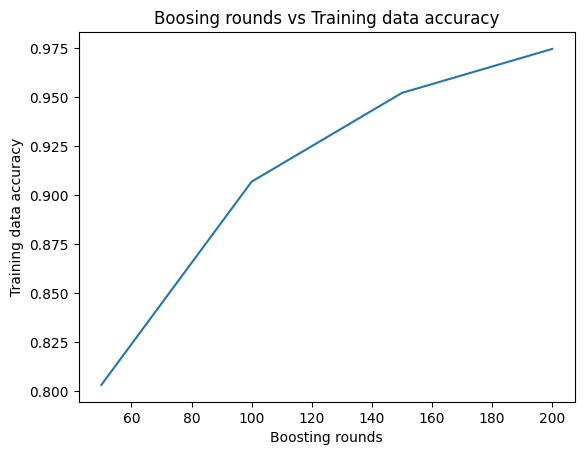

In [28]:
# Plot the training accuracies
import matplotlib.pyplot as plt
plt.plot(estimators, train_accuracies)
plt.xlabel('Boosting rounds')
plt.ylabel('Training data accuracy')
plt.title('Boosing rounds vs Training data accuracy')
plt.show()

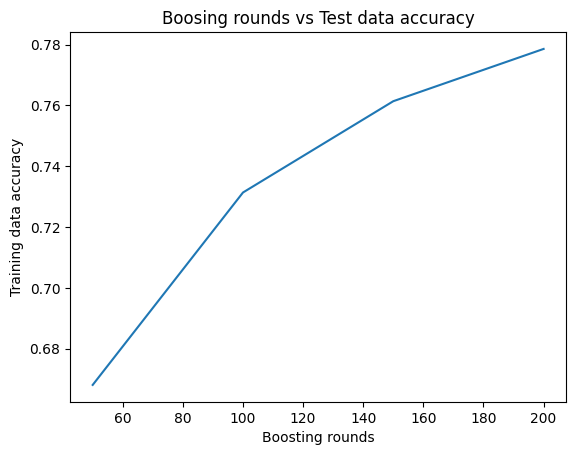

In [29]:
# Plot the test accuracies
plt.plot(estimators, test_accuracies)
plt.xlabel('Boosting rounds')
plt.ylabel('Training data accuracy')
plt.title('Boosing rounds vs Test data accuracy')
plt.show()